In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
# from scipy.stats import gaussian_kde
# import seaborn as sns
from scipy.integrate import trapz
# from matplotlib.colors import LinearSegmentedColormap
pd.options.display.max_rows=150 # para mostrar 150 filas
pd.options.display.max_columns=150 # para mostrar 150 columnas
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
# import time
# from scipy.optimize import curve_fit
# from sklearn.linear_model import LinearRegression
import itertools
from keras.optimizers import Adam, SGD
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
import keras
from keras import layers
import random
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
# from sklearn.datasets import fetch_openml
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import Ridge
# from sklearn import pipeline
# from sklearn.kernel_approximation import RBFSampler
# from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

#### Preparar datos

In [2]:
def minimo (a,b):
    return (0.5 * ( a+b - abs(a-b)))
 
def maximo (a,b):
    return (0.5 * ( a+b + abs(a-b)))

In [3]:
#TTS de Miguel
def TTS_eval(pf,cu,ni,mn,p,t,fl): 
    #fl un np.array
    if pf == 'F':
        A=1.011
        B=0.738
    elif (pf == 'P') or (pf == 'SRM'):
        A=1.080
        B=0.819
    elif pf == 'W':
        A=0.919
        B=0.968
    else:
        raise ValueError("Product Form no admisible")
        
    TTS1 = A*5/9*1.8943e-12*fl**(0.5695)*((1.8*t+32)/550)**(-5.47)*(0.09+p/0.012)**(0.216)*(1.66+ni**(8.54)/0.63)**(0.39)*(mn/1.36)**(0.3)

    M = B*maximo(minimo(113.87*(np.log(fl)-np.log(4.5e20)),612.6),0)*((1.8*t+32)/550)**(-5.45)*(0.1+p/0.012)**(-0.098)*(0.168+ni**(0.58)/0.63)**(0.73)

    TTS2 = 5/9*M*maximo((minimo(cu,0.28)-0.053),0)
    
    return TTS1+TTS2

In [4]:
df=pd.read_csv('df.csv') #contiene las medidas experimentales de plotter 

In [8]:
#añado AUC_astm a df para cada material 
Fl = np.array([i * 1e18 for i in range(1, int(1e20 / 1e18) + 1)])*1e4  # n/m2
df.reset_index(drop=True, inplace=True)
AUC_astm = np.full(np.shape(df)[0], np.nan)
for i in df.index:
    #no contar con HAZ product form 
    if df.loc[i][4] != 'HAZ' :
        if df.loc[i][4] == 'SRM':
            area = trapz(TTS_eval('P',df.loc[i][5],df.loc[i][6],df.loc[i][7],df.loc[i][8],df.loc[i][10],Fl),Fl*1e-23) 
            AUC_astm[i]=area
        else:
            area = trapz(TTS_eval(df.loc[i][4],df.loc[i][5],df.loc[i][6],df.loc[i][7],df.loc[i][8],df.loc[i][10],Fl),Fl*1e-23) 
            AUC_astm[i]=area
df['AUC_astm']=AUC_astm

In [9]:
df=df.dropna()

In [10]:
#datos de cada material
ml=df.drop_duplicates(subset=['MaterialLookup'])
ml = ml.drop(['Unnamed: 0'], axis=1)
ml.reset_index(drop=True, inplace=True)

In [11]:
#arreglar datos para entrenar con R algunos modelos
dfML = df.copy()
dfML = dfML.drop(['Unnamed: 0','Record_Number','Reactor_Type','MaterialLookup','Flux_n_cm2_s','AUC_astm'], axis=1)

In [12]:
y = dfML['DT41J_Celsius']
x = dfML.loc[:, dfML.columns != 'DT41J_Celsius']
x['Product_Form'].iloc[np.where(x['Product_Form']=='SRM')[0]] = 'P'
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.15, random_state=42)

In [13]:
scaler = StandardScaler()

In [14]:
xtrain.loc[:, xtrain.columns != 'Product_Form'] = scaler.fit_transform(xtrain.loc[:, xtrain.columns != 'Product_Form']) 
xtest.loc[:, xtest.columns != 'Product_Form'] = scaler.transform(xtest.loc[:, xtest.columns != 'Product_Form'])
x.loc[:, x.columns != 'Product_Form'] = scaler.transform(x.loc[:, x.columns != 'Product_Form'])

In [15]:
encoder = OneHotEncoder(sparse=False)
encoded_data = encoder.fit_transform(x[['Product_Form']])
xEncode = x.copy()
xEncode['Product_Form_F'] = encoded_data[:,0]
xEncode['Product_Form_P'] = encoded_data[:,1]
xEncode['Product_Form_W'] = encoded_data[:,2]
xEncode.drop('Product_Form', axis=1, inplace=True)

In [16]:
encoded_data = encoder.fit_transform(xtrain[['Product_Form']])
xtrainEncode = xtrain.copy()
xtrainEncode['Product_Form_F'] = encoded_data[:,0]
xtrainEncode['Product_Form_P'] = encoded_data[:,1]
xtrainEncode['Product_Form_W'] = encoded_data[:,2]
xtrainEncode.drop('Product_Form', axis=1, inplace=True)

In [17]:
encoded_data = encoder.fit_transform(xtest[['Product_Form']])
xtestEncode = xtest.copy()
xtestEncode['Product_Form_F'] = encoded_data[:,0]
xtestEncode['Product_Form_P'] = encoded_data[:,1]
xtestEncode['Product_Form_W'] = encoded_data[:,2]
xtestEncode.drop('Product_Form', axis=1, inplace=True)

In [18]:
def rmse(num1, num2):
    result = np.sqrt(mean_squared_error(num1,num2))
    return result

#### SVM

In [125]:
kernel_ridge_model = KernelRidge(kernel='rbf')
kernel_ridge_model.fit(xtrainEncode, ytrain)
DTpredKr = kernel_ridge_model.predict(xtestEncode)
rmse(ytest,DTpredKr)

16.416364055811055

#### NN

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, restore_best_weights=True) 

In [20]:
nep = 100 #num epochs

##### Regularizacion L1

In [21]:
#para PF en oneHotEncoding
def create_model(algoritmo, learning_rate, num_layer, size_layer, reg_lambda, mom,
                     activacion_salida, activacion_hidden, bnorm):
    #estructura red
    model = keras.Sequential()

    model.add(layers.Input(shape=(9,)))
    for i in range(num_layer):
        model.add(layers.Dense(size_layer, activation=activacion_hidden, kernel_regularizer = regularizers.L1(reg_lambda)))
        if bnorm:
            model.add(layers.BatchNormalization())
       
    model.add(layers.Dense(1, activation=activacion_salida, kernel_regularizer = regularizers.L1(reg_lambda)))

    #optimizador
    if algoritmo == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif algoritmo == 'sgd':
        opt = SGD(learning_rate=learning_rate, momentum = mom)

    model.compile(optimizer=opt,
                  loss='mse',
                  metrics=['mse'])
    return model

In [30]:
#optimizacion de parametros con cross-validacion
#grid de parametros

#ejemplo anterior
#best param
# {'algoritmo': 'adam',
#  'learning_rate': 0.01,
#  'num_layer': 4,
#  'size_layer': 50,
#  'reg_lambda': 0.0001,
#  'mom': 0.9,
#  'activacion_salida': 'relu',
#  'activacion_hidden': 'relu',
#  'bnorm': 1}
# best_loss
# 159.45091247558594

param = {
    'algoritmo': ['adam'], #'sgd',
    'learning_rate': [0.01, 0.001], 
    'num_layer': [3,5,7],
    'size_layer':[10,30,50],
    'reg_lambda':[0,0.0001,0.01], 
    'mom':[0.9], 
    'activacion_salida':['relu',layers.LeakyReLU(alpha=0.01)], 
    'activacion_hidden':['relu',layers.LeakyReLU(alpha=0.01)], 
    'bnorm':[1]
}
param_combinations = list(itertools.product(*param.values()))

best_loss = 1e10
best_param = {}

for combination in param_combinations:

    #asignamos el numero de neuronas para cada capa dada
    param_dict = dict(zip(param.keys(), combination))
    
    #compilamos y entrenamos el modelo
    model = create_model(**param_dict)

    history = model.fit(xtrainEncode, ytrain, epochs=nep, batch_size=128,
                                verbose=0, validation_data = (xtestEncode,ytest), callbacks = early_stopping)

    # Evaluar el modelo en el conjunto de prueba
    m_eval = model.evaluate(xtestEncode, ytest, batch_size=128)    
    val_loss = m_eval[1]

    # Actualizar el mejor modelo y los mejores parámetros si se obtiene un mejor rendimiento
    if val_loss < best_loss:
        best_loss = val_loss
        best_param = param_dict
            
# Mostrar los mejores parámetros encontrados y la mejor precisión
print("Mejor combinación de parámetros encontrada: ", best_param)
print("Mejor precisión en el conjunto de prueba: ", best_loss)

3/3 [==============================] - 0s 12ms/step - loss: 241.0219 - mse: 222.3603
Mejor combinación de parámetros encontrada:  {'algoritmo': 'adam', 'learning_rate': 0.01, 'num_layer': 5, 'size_layer': 50, 'reg_lambda': 0, 'mom': 0.9, 'activacion_salida': <keras.src.layers.activation.leaky_relu.LeakyReLU object at 0x000002AEE363ED50>, 'activacion_hidden': <keras.src.layers.activation.leaky_relu.LeakyReLU object at 0x000002AEE3674690>, 'bnorm': 1}
Mejor precisión en el conjunto de prueba:  161.15719604492188


In [31]:
best_param

{'algoritmo': 'adam',
 'learning_rate': 0.01,
 'num_layer': 5,
 'size_layer': 50,
 'reg_lambda': 0,
 'mom': 0.9,
 'activacion_salida': <keras.src.layers.activation.leaky_relu.LeakyReLU at 0x2aee363ed50>,
 'activacion_hidden': <keras.src.layers.activation.leaky_relu.LeakyReLU at 0x2aee3674690>,
 'bnorm': 1}

In [32]:
best_loss

161.15719604492188

In [33]:
#rmse sobre test
np.sqrt(best_loss)

12.694770421119157

In [34]:
#diseño modelo optimo
model = create_model(**best_param)

In [35]:
#entreno modelo optimo
random.seed(0)
history2 = model.fit(xtrainEncode, ytrain, epochs=nep, batch_size=128, 
              verbose=0, validation_data = (xtestEncode,ytest), callbacks = early_stopping)

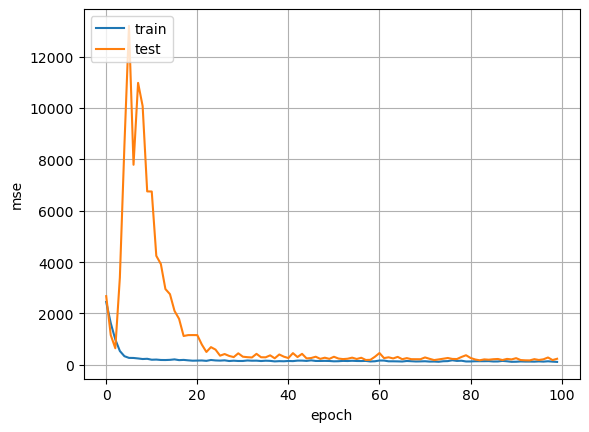

In [36]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)

##### Regularizacion L2

In [21]:
#para PF en oneHotEncoding
def create_model(algoritmo, learning_rate, num_layer, size_layer, reg_lambda, mom,
                     activacion_salida, activacion_hidden, bnorm):
    #estructura red
    model = keras.Sequential()

    model.add(layers.Input(shape=(9,)))
    for i in range(num_layer):
        model.add(layers.Dense(size_layer, activation=activacion_hidden, kernel_regularizer = regularizers.L2(reg_lambda)))
        if bnorm:
            model.add(layers.BatchNormalization())
       
    model.add(layers.Dense(1, activation=activacion_salida, kernel_regularizer = regularizers.L2(reg_lambda)))

    #optimizador
    if algoritmo == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif algoritmo == 'sgd':
        opt = SGD(learning_rate=learning_rate, momentum = mom)

    model.compile(optimizer=opt,
                  loss='mse',
                  metrics=['mse'])
    return model

In [22]:
#optimizacion de parametros con cross-validacion
#grid de parametros

#ejemplo anterior
#best param
# {'algoritmo': 'adam',
#  'learning_rate': 0.01,
#  'num_layer': 4,
#  'size_layer': 50,
#  'reg_lambda': 0.0001,
#  'mom': 0.9,
#  'activacion_salida': 'relu',
#  'activacion_hidden': 'relu',
#  'bnorm': 1}
# best_loss
# 159.45091247558594

param = {
    'algoritmo': ['adam'], #'sgd',
    'learning_rate': [0.01, 0.001], 
    'num_layer': [3,5,7],
    'size_layer':[10,30,50],
    'reg_lambda':[0,0.0001,0.01], 
    'mom':[0.9], 
    'activacion_salida':['relu',layers.LeakyReLU(alpha=0.01)], 
    'activacion_hidden':['relu',layers.LeakyReLU(alpha=0.01)], 
    'bnorm':[1]
}
param_combinations = list(itertools.product(*param.values()))

best_loss = 1e10
best_param = {}

for combination in param_combinations:

    #asignamos el numero de neuronas para cada capa dada
    param_dict = dict(zip(param.keys(), combination))
    
    #compilamos y entrenamos el modelo
    model = create_model(**param_dict)

    history = model.fit(xtrainEncode, ytrain, epochs=nep, batch_size=128,
                                verbose=0, validation_data = (xtestEncode,ytest), callbacks = early_stopping)

    # Evaluar el modelo en el conjunto de prueba
    m_eval = model.evaluate(xtestEncode, ytest, batch_size=128)    
    val_loss = m_eval[1]

    # Actualizar el mejor modelo y los mejores parámetros si se obtiene un mejor rendimiento
    if val_loss < best_loss:
        best_loss = val_loss
        best_param = param_dict
            
# Mostrar los mejores parámetros encontrados y la mejor precisión
print("Mejor combinación de parámetros encontrada: ", best_param)
print("Mejor precisión en el conjunto de prueba: ", best_loss)




3/3 [==============================] - 0s 0s/step - loss: 208.4771 - mse: 204.8892
Mejor combinación de parámetros encontrada:  {'algoritmo': 'adam', 'learning_rate': 0.01, 'num_layer': 3, 'size_layer': 30, 'reg_lambda': 0, 'mom': 0.9, 'activacion_salida': 'relu', 'activacion_hidden': <keras.src.layers.activation.leaky_relu.LeakyReLU object at 0x0000015E8992FA90>, 'bnorm': 1}
Mejor precisión en el conjunto de prueba:  159.10794067382812


In [23]:
best_param

{'algoritmo': 'adam',
 'learning_rate': 0.01,
 'num_layer': 3,
 'size_layer': 30,
 'reg_lambda': 0,
 'mom': 0.9,
 'activacion_salida': 'relu',
 'activacion_hidden': <keras.src.layers.activation.leaky_relu.LeakyReLU at 0x15e8992fa90>,
 'bnorm': 1}

In [24]:
best_loss

159.10794067382812

In [25]:
#rmse sobre test
np.sqrt(best_loss)

12.613799612877482

In [26]:
#diseño modelo optimo
model = create_model(**best_param)

In [27]:
#entreno modelo optimo
random.seed(0)
history2 = model.fit(xtrainEncode, ytrain, epochs=nep, batch_size=128, 
              verbose=0, validation_data = (xtestEncode,ytest), callbacks = early_stopping)

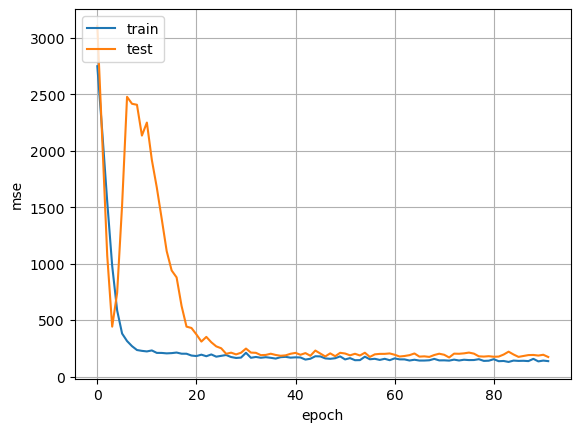

In [28]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)